<a href="https://colab.research.google.com/github/futartup/S8-S9-assignment/blob/master/QuizS9/S9-quiz-output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Add the current path to system path so that it can find the custom libraries

In [0]:
import os, sys
if '/content/drive/My Drive/Colab Notebooks/S8' not in sys.path:
  sys.path.append('/content/drive/My Drive/Colab Notebooks/S8')

# Import all the custom and inbuilt modules

In [3]:
!ls 
try:
  import ipynb
except:
  !pip install ipynb --upgrade
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torch.optim as optim
import os, sys

from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.functional as F



# custom apis
from ipynb.fs.full.transform_train_test_loader import *
import ipynb.fs.full.conf as conf

from ipynb.fs.full.train import train_model
from ipynb.fs.full.copy_test import test_model
from ipynb.fs.full.utils import *
from ipynb.fs.full.lr_finder import *
# import gradcam 
from ipynb.fs.full.resnet_gradcam import *


data  drive  sample_data


  pip install torch-lr-finder -v --global-option="amp"


# The model related code. Load the model from the conf file. 

In [4]:

if conf.custom_model['use']:
  #use custom model
  pass
elif conf.inbuilt_model['use']:
  from ipynb.fs.full.model.pytorch_resnet import *
  from ipynb.fs.full.model.resnet import *
  from ipynb.fs.full.model.QuizDNN import *
  model_type = conf.inbuilt_model['model']
  if model_type == 'DenseNet':
    net = globals()[model_type](growthRate=12, depth=50, reduction=0.5,
                            bottleneck=True, nClasses=10)
  else:
    net = globals()[model_type]()
  #net = torchvision.models.resnet18(pretrained=False)

Current Date/Time:  2020-04-01 17:01:52.168270


# Model Summary

In [5]:
use_cuda = torch.cuda.is_available()
if use_cuda:
  torch.cuda.manual_seed(conf.seed)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
       BatchNorm2d-2           [-1, 24, 32, 32]              48
            Conv2d-3           [-1, 48, 32, 32]           1,152
       BatchNorm2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 12, 32, 32]           5,184
        Bottleneck-6           [-1, 36, 32, 32]               0
       BatchNorm2d-7           [-1, 36, 32, 32]              72
            Conv2d-8           [-1, 48, 32, 32]           1,728
       BatchNorm2d-9           [-1, 48, 32, 32]              96
           Conv2d-10           [-1, 12, 32, 32]           5,184
       Bottleneck-11           [-1, 48, 32, 32]               0
      BatchNorm2d-12           [-1, 48, 32, 32]              96
           Conv2d-13           [-1, 48, 32, 32]           2,304
      BatchNorm2d-14           [-1

ipynb.fs.full.model.QuizDNN:123: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Test and Train loader

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), **conf.optimizer_parameters)

data_loader_obj = DataLoaderA(conf, './data')
train_loader = data_loader_obj.get_train_loader()
test_loader = data_loader_obj.get_test_loader()


Files already downloaded and verified


# Visualize the transformed images

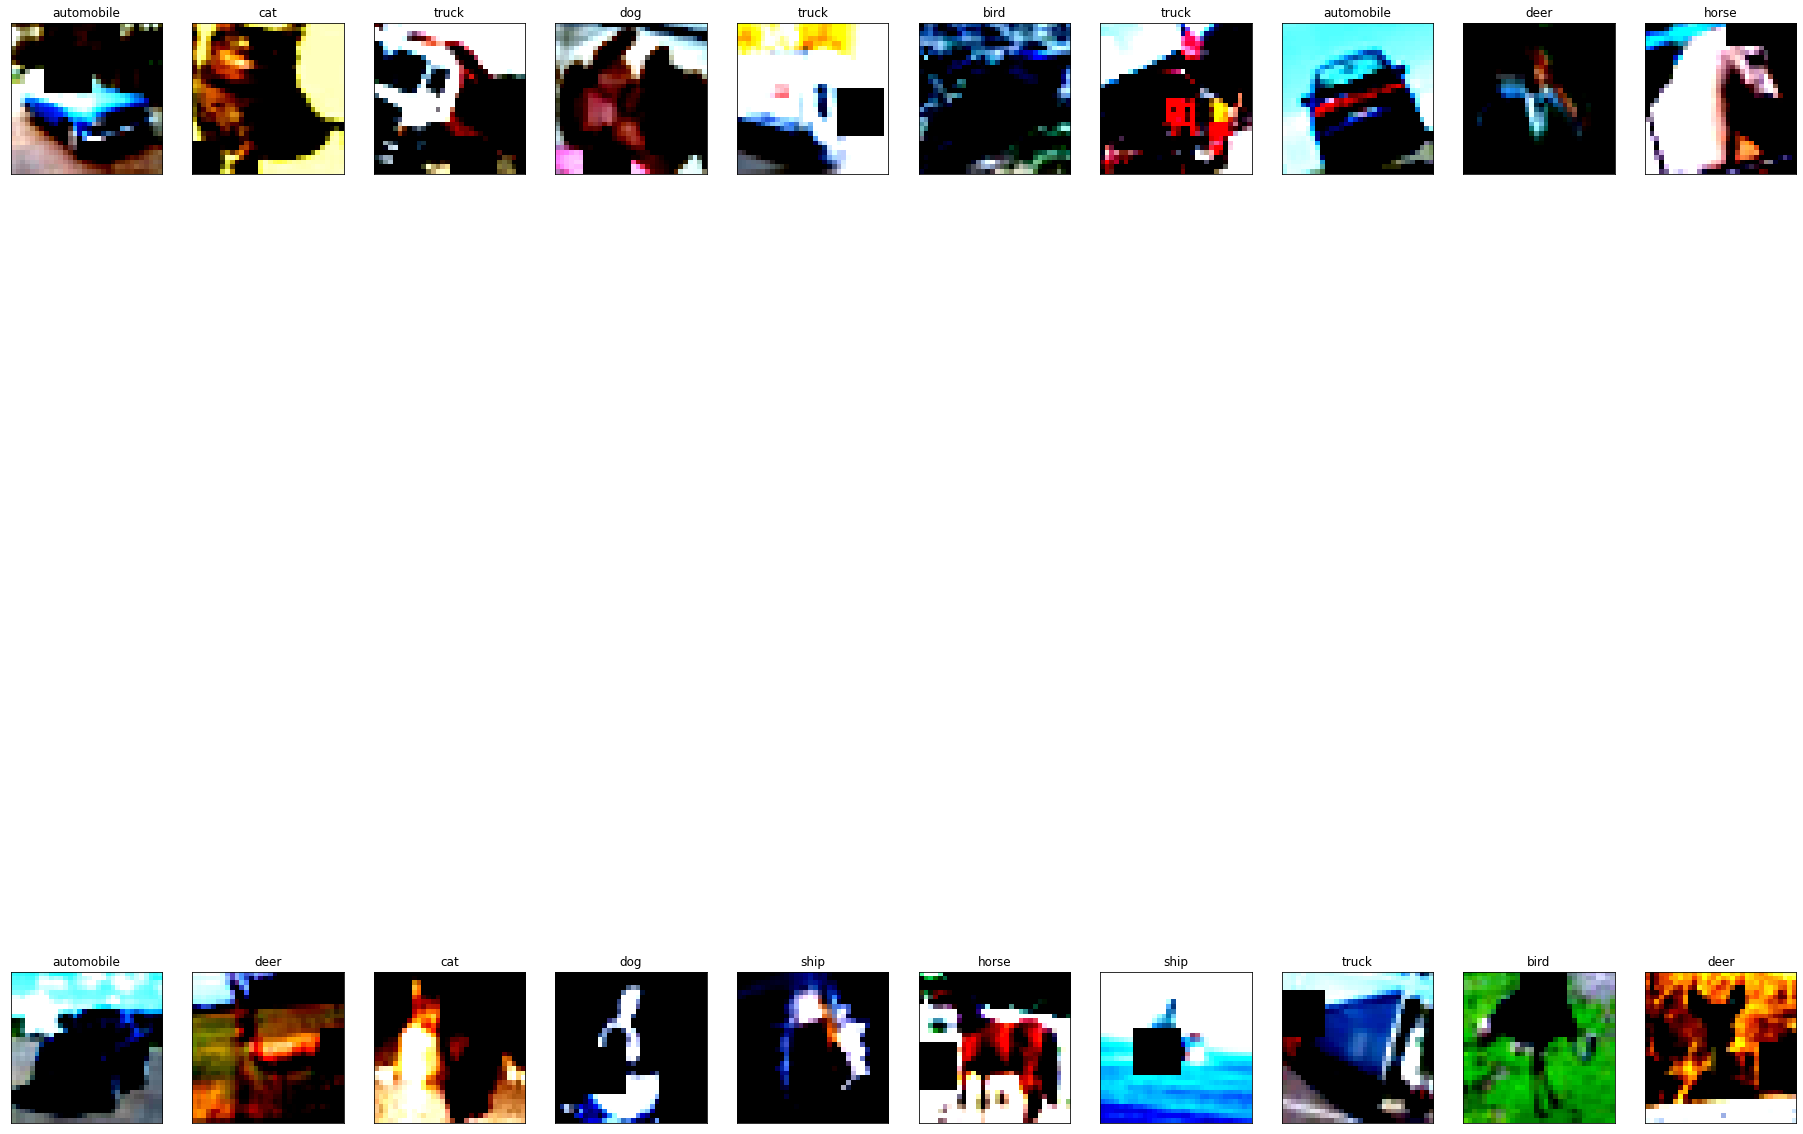

In [7]:
classes = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck",
}

images, labels = next(iter(train_loader))
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(32, 32))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(images[idx].transpose((1, 2, 0)))
    ax.set_title(classes[labels[idx].item()])

# Find the best LR

ipynb.fs.full.model.QuizDNN:123: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


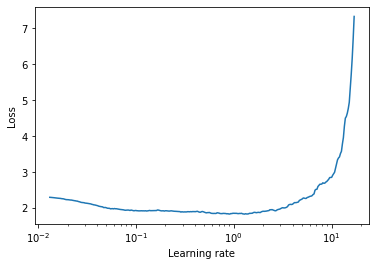

0.010471285480508996
1.2882495516931338


In [8]:
if conf.use_lr_finder_train:
  lr_finder = LRFinder(model, optimizer, criterion, device) #implemented LRFinder for SGD
  lr_finder.range_test(train_loader, end_lr=100, num_iter=400, step_mode="exp")
  lr_finder.plot() # to inspect the loss-learning rate graph
  #print(lr_finder.history) # see the history
  best_loss = lr_finder.best_loss
  print(min(lr_finder.history['lr']))
  print(lr_finder.history['lr'][lr_finder.history['loss'].index(best_loss)])
  optimizer.lr = lr_finder.history['lr'][lr_finder.history['loss'].index(best_loss)]
  lr_finder.reset()

scheduler = ReduceLROnPlateau(optimizer, mode=conf.mode, 
                              factor=conf.factor, patience=conf.patience,
                              verbose=conf.verbose, min_lr=1e-4)
#scheduler = StepLR(optimizer, lr_step_size, gamma=0.1)

# Test and Train

In [9]:
# Containers to plot the graph for test and train
test_losses = []
test_acc = []
train_losses = []
train_acc = []

# Containers for correctly and falsely predicted images
correct_predicted = []
false_predicted = []

# Number of images to display which are correct and false predicted
sample_count = 25

# TODO: Take the end epoch value from conf file 
for e in range(1, 50):
    print("epoch no: " , e)
    train_model(model, device, 
                train_loader, optimizer, 
                criterion, e,
                train_losses, train_acc)
    
    test_loss = test_model(model, device, 
                           test_loader, criterion, 
                           2, sample_count,
                           correct_predicted, false_predicted, 
                           test_losses, test_acc)
    scheduler.step(test_loss)
    print("===========================================================\n")



  0%|          | 0/782 [00:00<?, ?it/s]

epoch no:  1


ipynb.fs.full.model.QuizDNN:123: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=13.49488639831543 Batch_id=781 Accuracy=34.43: 100%|██████████| 782/782 [01:03<00:00, 12.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5309, Accuracy: 4327/10000 (43.27%)


epoch no:  2


Loss=10.469635963439941 Batch_id=781 Accuracy=46.75: 100%|██████████| 782/782 [01:03<00:00, 12.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5098, Accuracy: 4724/10000 (47.24%)


epoch no:  3


Loss=7.975755214691162 Batch_id=781 Accuracy=53.00: 100%|██████████| 782/782 [01:03<00:00, 12.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5782, Accuracy: 4741/10000 (47.41%)


epoch no:  4


Loss=6.410897254943848 Batch_id=781 Accuracy=56.29: 100%|██████████| 782/782 [01:03<00:00, 12.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.6944, Accuracy: 4364/10000 (43.64%)


epoch no:  5


Loss=4.874287128448486 Batch_id=781 Accuracy=59.16: 100%|██████████| 782/782 [01:02<00:00, 12.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1442, Accuracy: 5852/10000 (58.52%)


epoch no:  6


Loss=4.507008075714111 Batch_id=781 Accuracy=60.29: 100%|██████████| 782/782 [01:01<00:00, 12.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.6776, Accuracy: 4868/10000 (48.68%)


epoch no:  7


Loss=3.5411124229431152 Batch_id=781 Accuracy=61.68: 100%|██████████| 782/782 [01:02<00:00, 12.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4011, Accuracy: 5641/10000 (56.41%)


epoch no:  8


Loss=3.167161703109741 Batch_id=781 Accuracy=62.93: 100%|██████████| 782/782 [01:04<00:00, 12.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2255, Accuracy: 5839/10000 (58.39%)

Epoch     8: reducing learning rate of group 0 to 1.0000e-04.

epoch no:  9


Loss=3.7592530250549316 Batch_id=781 Accuracy=68.64: 100%|██████████| 782/782 [01:04<00:00, 12.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8115, Accuracy: 7102/10000 (71.02%)


epoch no:  10


Loss=3.6740665435791016 Batch_id=781 Accuracy=70.82: 100%|██████████| 782/782 [01:03<00:00, 12.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7919, Accuracy: 7154/10000 (71.54%)


epoch no:  11


Loss=3.266862630844116 Batch_id=781 Accuracy=71.66: 100%|██████████| 782/782 [01:03<00:00, 12.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7845, Accuracy: 7220/10000 (72.20%)


epoch no:  12


Loss=3.26739764213562 Batch_id=781 Accuracy=72.14: 100%|██████████| 782/782 [01:03<00:00, 12.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7657, Accuracy: 7297/10000 (72.97%)


epoch no:  13


Loss=3.2344584465026855 Batch_id=781 Accuracy=72.22: 100%|██████████| 782/782 [01:03<00:00, 12.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7550, Accuracy: 7348/10000 (73.48%)


epoch no:  14


Loss=3.2225165367126465 Batch_id=781 Accuracy=72.24: 100%|██████████| 782/782 [01:03<00:00, 12.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7511, Accuracy: 7384/10000 (73.84%)


epoch no:  15


Loss=3.4320545196533203 Batch_id=781 Accuracy=72.79: 100%|██████████| 782/782 [01:03<00:00, 12.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7342, Accuracy: 7446/10000 (74.46%)


epoch no:  16


Loss=2.780534505844116 Batch_id=781 Accuracy=72.97: 100%|██████████| 782/782 [01:03<00:00, 12.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7346, Accuracy: 7414/10000 (74.14%)


epoch no:  17


Loss=3.018932819366455 Batch_id=781 Accuracy=73.39: 100%|██████████| 782/782 [01:03<00:00, 12.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7203, Accuracy: 7475/10000 (74.75%)


epoch no:  18


Loss=2.9704384803771973 Batch_id=781 Accuracy=73.47: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7220, Accuracy: 7468/10000 (74.68%)


epoch no:  19


Loss=2.762512683868408 Batch_id=781 Accuracy=73.42: 100%|██████████| 782/782 [01:02<00:00, 12.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7111, Accuracy: 7500/10000 (75.00%)


epoch no:  20


Loss=3.4420201778411865 Batch_id=781 Accuracy=73.99: 100%|██████████| 782/782 [01:03<00:00, 12.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7334, Accuracy: 7426/10000 (74.26%)


epoch no:  21


Loss=3.1628026962280273 Batch_id=781 Accuracy=73.98: 100%|██████████| 782/782 [01:02<00:00, 12.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7192, Accuracy: 7478/10000 (74.78%)


epoch no:  22


Loss=2.7632453441619873 Batch_id=781 Accuracy=74.00: 100%|██████████| 782/782 [01:01<00:00, 12.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6999, Accuracy: 7572/10000 (75.72%)


epoch no:  23


Loss=3.190938949584961 Batch_id=781 Accuracy=74.39: 100%|██████████| 782/782 [01:01<00:00, 12.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6919, Accuracy: 7565/10000 (75.65%)


epoch no:  24


Loss=2.8293075561523438 Batch_id=781 Accuracy=74.48: 100%|██████████| 782/782 [01:01<00:00, 12.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6958, Accuracy: 7547/10000 (75.47%)


epoch no:  25


Loss=3.067197799682617 Batch_id=781 Accuracy=74.44: 100%|██████████| 782/782 [01:01<00:00, 12.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6933, Accuracy: 7579/10000 (75.79%)


epoch no:  26


Loss=3.0218875408172607 Batch_id=781 Accuracy=74.89: 100%|██████████| 782/782 [01:01<00:00, 12.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6891, Accuracy: 7591/10000 (75.91%)


epoch no:  27


Loss=2.9290621280670166 Batch_id=781 Accuracy=74.77: 100%|██████████| 782/782 [01:01<00:00, 12.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6903, Accuracy: 7608/10000 (76.08%)


epoch no:  28


Loss=2.7292771339416504 Batch_id=781 Accuracy=74.88: 100%|██████████| 782/782 [01:04<00:00, 12.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6756, Accuracy: 7647/10000 (76.47%)


epoch no:  29


Loss=2.540761947631836 Batch_id=781 Accuracy=74.87: 100%|██████████| 782/782 [01:03<00:00, 12.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6598, Accuracy: 7714/10000 (77.14%)


epoch no:  30


Loss=3.091658353805542 Batch_id=781 Accuracy=75.10: 100%|██████████| 782/782 [01:02<00:00, 12.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6948, Accuracy: 7579/10000 (75.79%)


epoch no:  31


Loss=2.52801513671875 Batch_id=781 Accuracy=75.49: 100%|██████████| 782/782 [01:03<00:00, 12.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6891, Accuracy: 7623/10000 (76.23%)


epoch no:  32


Loss=2.871835470199585 Batch_id=517 Accuracy=75.45:  66%|██████▌   | 517/782 [00:42<00:21, 12.25it/s]

KeyboardInterrupt: ignored

# *GradCam* for Resnet for falsely predicted images


In [0]:

images = [x['image'].unsqueeze(0) for x in false_predicted]
inputs = [i.to(device) for i in images]
gradcamof(model, inputs, classes)

# Correctly predicted images

In [0]:
matplotlib_imshow(classes, correct_predicted, plt, False)

# Falsely predicted images

In [0]:
matplotlib_imshow(classes, false_predicted, plt, False)

# Plot The Graph for train and test 

In [0]:
plottesttraingraph([x.item() for x in train_losses], train_acc, test_losses, test_acc, plt, True)